In [2]:
pip install osmnx

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install ortools

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


### Import Libraries 

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import folium
import plotly.express as px
import osmnx as ox
import networkx as nx
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

### Import Data and select city, dropping all other cities

In [137]:
city = 'Manchester'
df=pd.read_csv('directory.csv')
df=df[df['City']== city][['Street Address', 'Latitude', 'Longitude']].reset_index(drop=True)
df=df.reset_index().rename(columns={'index':'id', 'Latitude':'y', 'Longitude':'x'})
print('total', len(df))
df.head(5)

total 36


,id,Street Address,y,x
0,0,Nelson St,53.46,-2.23
1,1,Terminal One,53.37,-2.28
2,2,"Unit 7B, First Street",53.47,-2.25
3,3,"Piccadilly Station, New Cannon",53.48,-2.23
4,4,"Arndale Centre, Unit R2",53.48,-2.24


### Update Dataframe, adding colors to start and locations

In [181]:
data = df.copy()
data['color']=''
data.loc[data['id']==0, 'color']='red'
data.loc[data['id']!=0, 'color']='black'
start=data[data['id']==0][['y','x']].values[0]
data.head(3)
print('Starting Point:', start)

Starting Point: [53.46 -2.23]


### Plot Locations 

In [184]:
map =folium.Map(location=start, titles = 'cartodbpositron', zoom_start=10)
data.apply(lambda row:
           folium.CircleMarker(
               location=[row['y'], row['x']],
               color=row['color'],fill=True, radius = 5).add_to(map), axis =1)
map
                   

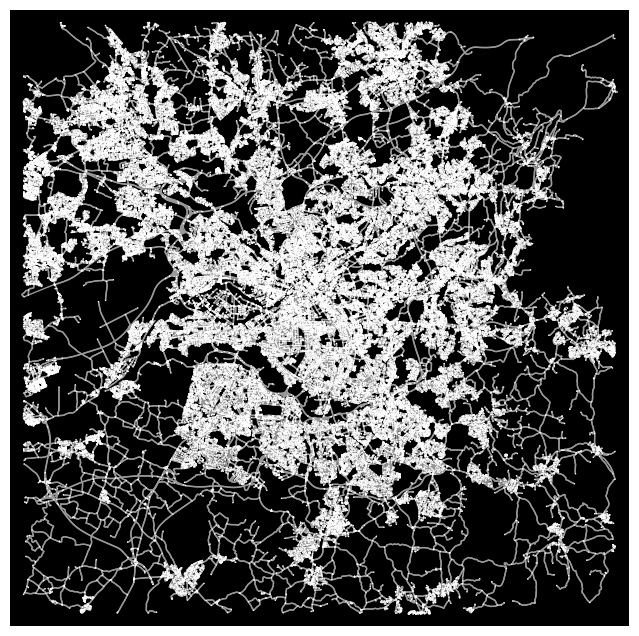

In [153]:
G=ox.graph_from_point(start,dist=20000, network_type = 'drive')
G=ox.add_edge_speeds(G)
G=ox.add_edge_travel_times(G)
fig, ax = ox.plot_graph(G, bgcolor = 'black', node_size = 1, node_color = 'white', figsize = (16,8)) 

In [154]:
start_node=ox.distance.nearest_nodes(G, start[1], start[0])
df["node"]=df[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
df=df.drop_duplicates("node", keep='first')
df.head()

/var/folders/bw/_z9gq4lj48b6tvr4294sx9yw0000gp/T/ipykernel_91049/1688938705.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/bw/_z9gq4lj48b6tvr4294sx9yw0000gp/T/ipykernel_91049/1688938705.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/bw/_z9gq4lj48b6tvr4294sx9yw0000gp/T/ipykernel_91049/1688938705.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/bw/_z9gq4lj48b6tvr4294sx9yw0000gp/T/ipy

,id,Street Address,y,x,node
0,0,Nelson St,53.46,-2.23,3356864
1,1,Terminal One,53.37,-2.28,20910602
2,2,"Unit 7B, First Street",53.47,-2.25,6160129764
3,3,"Piccadilly Station, New Cannon",53.48,-2.23,306568837
4,4,"Arndale Centre, Unit R2",53.48,-2.24,4831689


In [155]:
def f(a , b):
    try:
        d=nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d=np.nan
    return d

distance_matrix=np.asarray([[f(a,b)for b in df["node"].tolist()] for a in df["node"].tolist()])
distance_matrix=pd.DataFrame(distance_matrix, columns=df["node"].values, index=df["node"].values)

distance_matrix.head()


,3356864,20910602,6160129764,306568837,4831689,11618846961,324685631,30822478,1578759119,1295285459,30772938,5092787125,25400718,1431056544,957662176
3356864,0.000000,764.252220,260.956936,352.665473,329.774631,232.132191,372.779972,676.793531,494.041025,638.462658,311.521037,177.344515,560.763006,818.482947,1474.437020
20910602,743.897837,0.000000,740.271849,882.710947,858.791483,814.339562,894.592182,555.673553,997.499387,628.563090,569.295466,771.071150,288.843530,269.752542,1486.199835
6160129764,260.956936,764.219699,0.000000,271.693908,247.774445,221.621270,280.066076,517.372514,353.719734,479.041641,400.776509,136.700446,650.018478,818.450426,1318.027849
306568837,316.004362,871.430524,245.223934,0.000000,160.186732,132.755010,221.462008,634.357609,169.923205,596.026736,465.467414,191.083436,643.738021,925.661251,1432.001098
4831689,329.816434,882.844405,256.637815,114.337154,0.000000,151.362502,95.021329,627.156959,191.131062,588.826086,464.607280,209.690928,642.877887,937.075133,1425.831991


In [156]:
distance_matrix=distance_matrix.round()
distance_matrix=distance_matrix.astype('float')
distance_matrix

,3356864,20910602,6160129764,306568837,4831689,11618846961,324685631,30822478,1578759119,1295285459,30772938,5092787125,25400718,1431056544,957662176
3356864,0.0,764.0,261.0,353.0,330.0,232.0,373.0,677.0,494.0,638.0,312.0,177.0,561.0,818.0,1474.0
20910602,744.0,0.0,740.0,883.0,859.0,814.0,895.0,556.0,997.0,629.0,569.0,771.0,289.0,270.0,1486.0
6160129764,261.0,764.0,0.0,272.0,248.0,222.0,280.0,517.0,354.0,479.0,401.0,137.0,650.0,818.0,1318.0
306568837,316.0,871.0,245.0,0.0,160.0,133.0,221.0,634.0,170.0,596.0,465.0,191.0,644.0,926.0,1432.0
4831689,330.0,883.0,257.0,114.0,0.0,151.0,95.0,627.0,191.0,589.0,465.0,210.0,643.0,937.0,1426.0
11618846961,232.0,823.0,197.0,159.0,178.0,0.0,240.0,586.0,306.0,548.0,356.0,138.0,534.0,878.0,1384.0
324685631,339.0,846.0,199.0,229.0,146.0,246.0,0.0,538.0,256.0,500.0,482.0,214.0,692.0,900.0,1332.0
30822478,694.0,584.0,517.0,676.0,623.0,627.0,569.0,0.0,643.0,155.0,729.0,569.0,642.0,638.0,1063.0
1578759119,453.0,1009.0,359.0,165.0,289.0,270.0,224.0,654.0,0.0,631.0,583.0,328.0,762.0,1063.0,1426.0
1295285459,644.0,670.0,468.0,627.0,574.0,577.0,555.0,158.0,628.0,0.0,743.0,520.0,729.0,725.0,1207.0


In [157]:
drivers = 1
lst_nodes=df['node'].tolist()
print('start:', start_node, 'total locations to visit', len(lst_nodes)-1, 'drivers', drivers)

start: 3356864 total locations to visit 14 drivers 1


In [158]:
manager = pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model = pywrapcp.RoutingModel(manager)
                                
                             

In [159]:
def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index, to_index]

distance=model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy= (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [160]:
solution= model.SolveWithParameters(parameters)

index=model.Start(0)
print('route for driver:')
route_idx, route_distance = [], 0

while not model.IsEnd(index):
    route_idx.append(manager.IndexToNode(index))
    previous_index=index
    index=solution.Value(model.NextVar(index))
    
    try:
        route_distance +=get_distance(previous_index, index)
    except:
        route_distance+=model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)
        
print(route_idx)
print(f'Total distance:{round(route_distance/1000,2)}km')
print(f'Nodes visited: {len(route_idx)}')
map

route for driver:
[0, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
Total distance:8.53km
Nodes visited: 15


In [161]:
print("Route for driver (nodes):")
lst_route=[lst_nodes[i] for i in route_idx]
print(lst_route)

Route for driver (nodes):
[3356864, 957662176, 1431056544, 25400718, 5092787125, 30772938, 1295285459, 1578759119, 30822478, 324685631, 11618846961, 4831689, 306568837, 6160129764, 20910602]


In [162]:
def get_path_between_nodes(lst_route):
    lst_paths=[]
    for i in range (len(lst_route)):
        try :
            a , b = lst_nodes[i], lst_nodes[i+1]
        except:
            break
        try:
            path=nx.shortest_path(G, source=a, target=b, method ='dijkstra', weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except:
            continue
    return lst_paths

lst_paths= get_path_between_nodes(lst_route)


In [163]:
def df_animation_multiple_path(G, lst_paths, parallel=True):
    df1=pd.DataFrame()
    for path in lst_paths :
        lst_start, lst_end = [] , []
        start_x, start_y = [] , []
        end_x, end_y = [], []
        lst_length, lst_time = [], [] 
        
        for a , b in zip (path[:-1], path[1:]):
            lst_start.append(a)
            lst_end.append(b)
            lst_length.append(round(G.edges[(a,b,0)]['length']))
            lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
            start_x.append(G.nodes[a]['x'])
            start_y.append(G.nodes[a]['y'])
            end_x.append(G.nodes[b]['x'])
            end_y.append(G.nodes[b]['y'])
            
        tmp=pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)), 
                         columns= ["start", "end", "start_x", "start_y", "end_x", "end_y", "length", "travel_time"])
        df1=pd.concat([df1,tmp], ignore_index=(not parallel))
        
    df1=df1.reset_index().rename(columns={"index":"id"})
    return df1

In [164]:
tmp.head(20)


,id,start,end,start_x,start_y,end_x,end_y,length,travel_time
0,0,289796441,293557419,-81.260399,42.989256,-81.258445,42.989189,159,11
1,1,293557419,12120514859,-81.258445,42.989189,-81.256653,42.988821,152,16
2,2,12120514859,12120514837,-81.256653,42.988821,-81.256557,42.988542,32,6
3,3,12120514837,12120514844,-81.256557,42.988542,-81.256466,42.988375,33,3
4,4,12120514844,12120514831,-81.256466,42.988375,-81.256294,42.988247,20,4
5,5,12120514831,303912843,-81.256294,42.988247,-81.256009,42.987773,58,5
6,6,303912843,306221191,-81.256009,42.987773,-81.254460,42.988195,134,7
7,7,306221191,306221184,-81.254460,42.988195,-81.253951,42.987171,121,9
8,8,306221184,293557425,-81.253951,42.987171,-81.253382,42.986044,134,10
9,9,293557425,289796390,-81.253382,42.986044,-81.251113,42.986667,197,15


In [165]:
df1= pd.DataFrame()
tmp=df_animation_multiple_path(G, lst_paths, parallel=False)
df1=pd.concat([df1, tmp], axis=0)
first_node, last_node= lst_paths[0][0], lst_paths[-1][-1]

/Users/leewilson/anaconda3/lib/python3.11/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



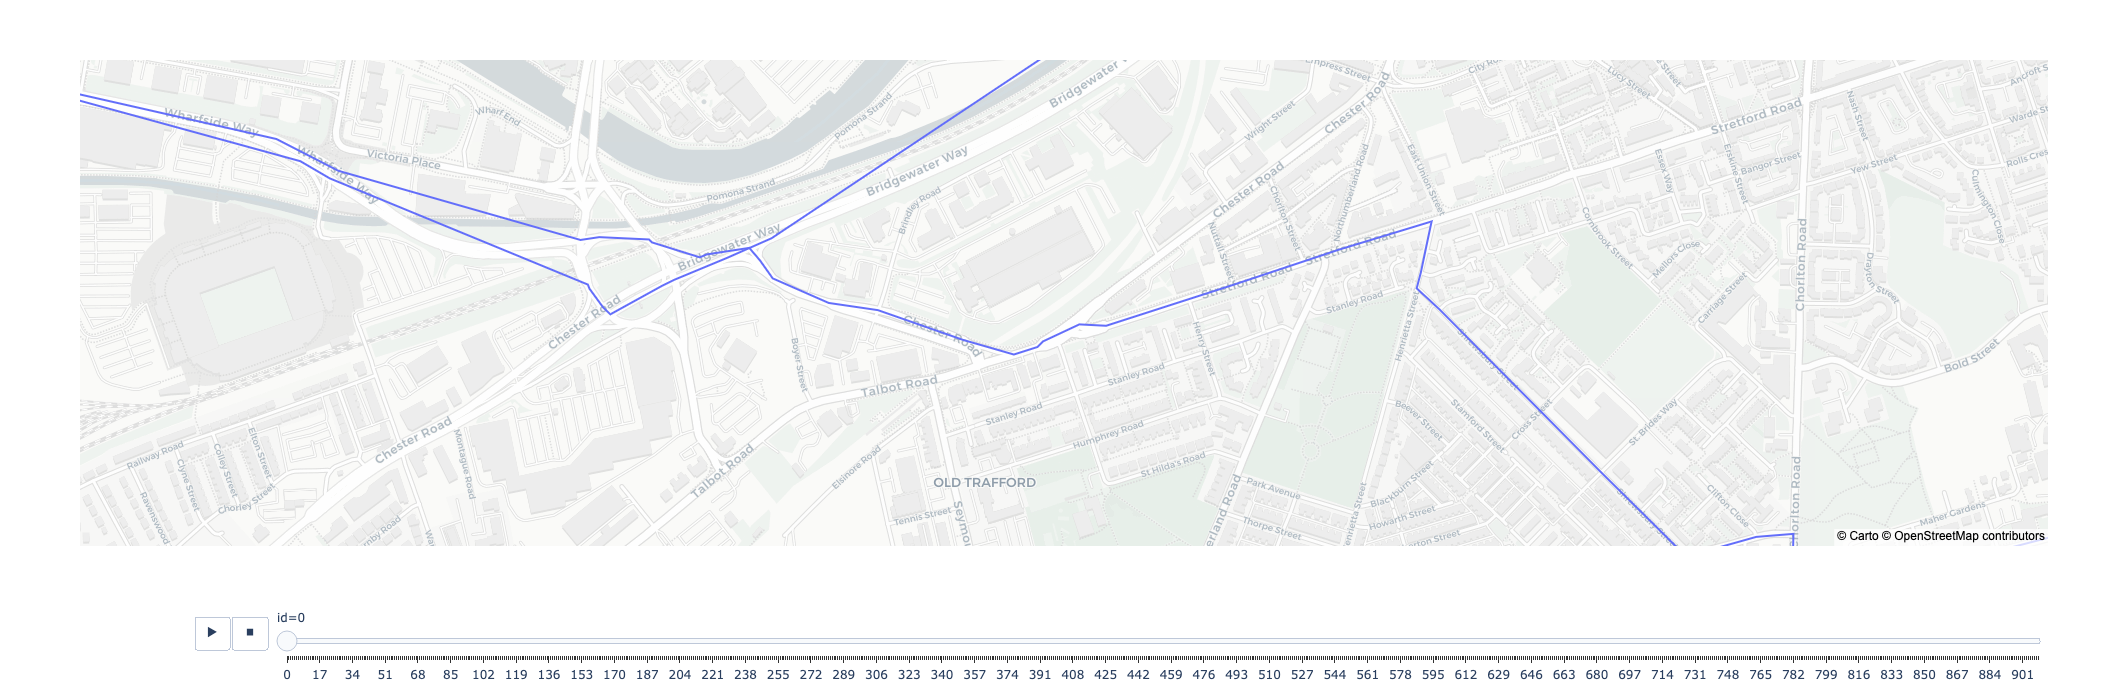

In [166]:
df_start= df1[df1["start"]== first_node]
df_end=df1[df1["end"]== last_node]

fig=px.scatter_mapbox(data_frame=df1, lon="start_x", lat="start_y", zoom=15, width=900, height=700, animation_frame="id",mapbox_style="carto-positron")

fig.data[0].marker={"size":12}

fig.add_trace(px.scatter_mapbox(data_frame=df, lon="x", lat="y").data[0])
fig.data[1].marker={"size":10, "color":"black"}

fig.add_trace(px.scatter_mapbox(data_frame=df_start, lon="start_x", lat="start_y").data[0])
fig.data[2].marker={"size":15, "color":"red"}

fig.add_trace(px.scatter_mapbox(data_frame=df_end, lon="start_x", lat="start_y").data[0])
fig.data[3].marker={"size":15, "color":"green"}

fig.add_trace(px.line_mapbox(data_frame=df1, lon="start_x", lat="start_y").data[0])

fig